# <a href="https://miptstats.github.io/courses/ad_fivt.html">Введение в анализ данных</a>
## Домашнее задание 5. Компьютерное зрение & генеративные модели


**Правила, <font color="red">прочитайте внимательно</font>:**

* Выполненную работу нужно отправить телеграм-боту `@miptstats_ds24_bot`. Для начала работы с ботом каждый раз отправляйте `/start`. **Работы, присланные иным способом, не принимаются.**
* Дедлайн см. в боте. После дедлайна работы не принимаются кроме случаев наличия уважительной причины.
* Прислать нужно **ноутбук в формате `ipynb`**.
* Следите за размером файлов. **Бот не может принимать файлы весом более 20 Мб.** Если файл получается больше, заранее разделите его на несколько.
* Выполнять задание необходимо полностью самостоятельно. **При обнаружении списывания все участники списывания будут сдавать устный зачет.**
* Решения, размещенные на каких-либо интернет-ресурсах, не принимаются. Кроме того, публикация решения в открытом доступе может быть приравнена к предоставлении возможности списать.
* Для выполнения задания используйте этот ноутбук в качестве основы, ничего не удаляя из него. Можно добавлять необходимое количество ячеек.
* Комментарии к решению пишите в markdown-ячейках.
* Выполнение задания (ход решения, выводы и пр.) должно быть осуществлено на русском языке.
* Если код будет не понятен проверяющему, оценка может быть снижена.
* Никакой код из данного задания при проверке запускаться не будет. *Если код студента не выполнен, недописан и т.д., то он не оценивается.*


**Баллы за задание:**

* Задача 1 &mdash; 150 баллов
* Задача 2 &mdash; 40 баллов

Баллы учитываются в <b><font color="green">факультативной части</font></b> курса и не влияют на оценку по основной части.

In [ ]:
# Bot check

# HW_ID: fpmi_ad5
# Бот проверит этот ID и предупредит, если случайно сдать что-то не то.

# Status: final
# Перед отправкой в финальном решении удали "not" в строчке выше.
# Так бот проверит, что ты отправляешь финальную версию, а не промежуточную.
# Никакие значения в этой ячейке не влияют на факт сдачи работы.

In [ ]:
!pip install torchinfo

In [ ]:
import time
import warnings
from collections import defaultdict
from tqdm import tqdm

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchinfo import summary

from IPython.display import clear_output
sns.set(font_scale=1, style='darkgrid', palette='Set2')
warnings.simplefilter("ignore")

device = f"cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


Перед выполнением задания обязательно посмотрите <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_1.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_classification.html" target="_blank">ноутбук</a> про сверточные сети и классификацию, а так же <a href="https://miptstats.github.io/courses/ad_fivt/lecture5_2.pdf" target="_blank">презентацию</a> и <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">ноутбук</a> про перенос стиля и генеративные сети.

---
### Задача 1. Классификация MNIST


Цель: сравнить сверточные нейросети с разными параметрами на датасете рукописных цифр MNIST. В нем содержатся черно-белые изображения цифр, всего 10 классов для каждой цифры. Пользоваться кодом семинара можно без ограничений. Классификация MNIST намного легче, чем CIFAR, поэтому ваша задача хотя бы в одной из моделей получить 98% точности **на валидации**.

> Использования слоев с семинара (свертка, pooling) более чем достаточно для достижения 98% точности на тесте. Также не делайте сеть глубокой.

> Тестируйте работоспособность кода на CPU с небольшим кол-вом итераций. Если все работает, и хочется ускорить процесс, переходите на GPU.

Следуйте указаниям ниже.

Загрузим датаcет из `torchvision.datasets`.

In [ ]:
# Данные для обучения
train_dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                           download=True,
                                           transform=transforms.ToTensor())
# Данные для тестирования
val_dataset = torchvision.datasets.MNIST(root='./data', train=False,
                                         download=True,
                                         transform=transforms.ToTensor())
# Классы объектов в датасете
classes = [str(i) for i in range(10)]

print(len(train_dataset), len(val_dataset))

60000 10000


Визуализируйте несколько картинок с соответствующими метками из датасета.

Размер картинки:torch.Size([1, 28, 28])


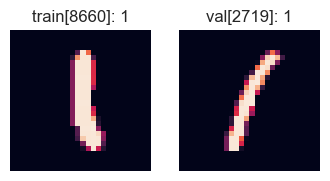

In [ ]:
# берем 2 рандомных индекса
train_idx, val_idx = np.random.randint(0, 10000, 2)
print(f"Размер картинки:{train_dataset[0][0].shape}")

# визуализируем
plt.figure(figsize=(4, 2))
plt.subplot(1, 2, 1)
plt.imshow(train_dataset[train_idx][0].permute(1, 2, 0))
plt.title(f"train[{train_idx}]: {classes[train_dataset[train_idx][1]]}")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(val_dataset[val_idx][0].permute(1, 2, 0))
plt.title(f"val[{val_idx}]: {classes[val_dataset[val_idx][1]]}")
plt.axis("off");

Создайте генераторы батчей.

In [ ]:
batch_size = 64

train_batch_gen = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True
)
val_batch_gen = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False
)

**Эксперимент 1.** Создайте хотя бы 5 сверточных нейросетей с разным количеством линейных и сверточных слоев. Должен присутствовать хотя бы 1 сверточный слой и хотя бы 1 линейный слой. Для каждой посмотрите количество параметров с помощью `torchinfo.summary`.

In [ ]:
cnn_1 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=500, out_features=128),
    nn.ReLU(),
    nn.Linear(in_features=128, out_features=10),
).to(device)

cnn_2 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4732, out_features=10),
).to(device)

cnn_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=4732, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

cnn_4 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1400, out_features=10),
).to(device)

cnn_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1400, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

print("CNN1:", summary(cnn_1, input_size=(1, 1, 28, 28)))
print("CNN2:", summary(cnn_2, input_size=(1, 1, 28, 28)))
print("CNN3:", summary(cnn_3, input_size=(1, 1, 28, 28)))
print("CNN4:", summary(cnn_4, input_size=(1, 1, 28, 28)))
print("CNN5:", summary(cnn_5, input_size=(1, 1, 28, 28)))

CNN1: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 10, 26, 26]           100
├─MaxPool2d: 1-2                         [1, 10, 13, 13]           --
├─ReLU: 1-3                              [1, 10, 13, 13]           --
├─Conv2d: 1-4                            [1, 20, 11, 11]           1,820
├─MaxPool2d: 1-5                         [1, 20, 5, 5]             --
├─ReLU: 1-6                              [1, 20, 5, 5]             --
├─Flatten: 1-7                           [1, 500]                  --
├─Linear: 1-8                            [1, 128]                  64,128
├─ReLU: 1-9                              [1, 128]                  --
├─Linear: 1-10                           [1, 10]                   1,290
Total params: 67,338
Trainable params: 67,338
N

Если посмотреть на характеристики сетей, то видно, что получились они разные: одна на 67 тыс. параметров, одна на 47 тыс., одна на 28 тыс., одна на 375 тыс. и одна на 1214 тыс. Получилось так, что две сети сильно отличаются по количество обучаемых парамаетров. Далее мы сравним разницу между результатами обучения.

Обучите сети, используя функцию потерь `nn.CrossEntropyLoss` и оптимизатор `torch.optim.Adam` с дефолтными параметрами.

In [ ]:
def print_epoch(epoch, num_epochs, history, t):
    """
    Функция для вывода информации про эпоху.
    :param epoch: номер эпохи
    :param num_epochs: общее количество эпох
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param t: время эпохи в секундах
    """
    clear_output(wait=True)
    print("Epoch {} of {} took {:.3f} s".format(epoch + 1, num_epochs, t))
    print("  training loss: \t{:.6f}".format(history["loss"]["train"][-1]))
    print("  validation loss: \t{:.6f}".format(history["loss"]["val"][-1]))
    print(
        "  training accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["train"][-1] * 100
        )
    )
    print(
        "  validation accuracy: \t\t\t{:.2f} %".format(
            history["acc"]["val"][-1] * 100
        )
    )


def update_history(history, loss, acc, num_batches, mode):
    """
    Функция для сохранения лосса и точности в историю.
    :param history: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    :param loss: сумма лосса за весь батч
    :param acc: сумма точности за весь батч
    :param num_batches: общее количество батчей
    :param mode: train или val
    """
    # Подсчитываем лоссы и сохраняем в "историю"
    loss /= num_batches
    acc /= num_batches
    history["loss"][mode].append(loss)
    history["acc"][mode].append(acc)


def get_batch_loss(
    X_batch, y_batch, model, criterion, current_loss, current_acc
):
    """
    Функция для подсчета лосса (без backward pass).
    :param X_batch: батч картиок X
    :param y_batch: батч меток y
    :param model: модель для получения логитов
    :param criterion: функция потерь
    :param current_loss: текущий суммарный лосс за батч
    :param current_acc: текущая суммарная точность за батч
    :return: лосс на данном батче; current_loss; current_acc
    """

    # Обучаемся на батче (одна "итерация" обучения нейросети)
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    # Логиты на выходе модели
    logits = model(X_batch)

    # Подсчитываем лосс
    loss = criterion(logits, y_batch.long().to(device))

    # Сохраняем лоссы и точность на трейне
    current_loss += loss.detach().cpu().numpy()
    y_pred = logits.max(1)[1].detach().cpu().numpy()
    current_acc += np.mean(y_batch.cpu().numpy() == y_pred)
    return loss, current_loss, current_acc


def train(
    model, criterion, optimizer, train_batch_gen, val_batch_gen, num_epochs=40
):
    """
    Функция для обучения модели и вывода лосса и метрики во время обучения.

    :param model: обучаемая модель
    :param criterion: функция потерь
    :param optimizer: метод оптимизации
    :param train_batch_gen: генератор батчей для обучения
    :param val_batch_gen: генератор батчей для валидации
    :param num_epochs: количество эпох
    :return: (dict) accuracy и loss на обучении и валидации ("история" обучения)
    """

    history = defaultdict(lambda: defaultdict(list))

    for epoch in range(num_epochs):
        train_loss, val_loss = 0, 0
        train_acc, val_acc = 0, 0
        start_time = time.time()

        # ----------------------   ОБУЧЕНИЕ   ----------------------#
        model.train(True)
        # На каждой "эпохе" делаем полный проход по данным
        for X_batch, y_batch in train_batch_gen:
            # Считаем лосс, обновляем train_loss, train_acc
            loss, train_loss, train_acc = get_batch_loss(
                X_batch, y_batch, model, criterion, train_loss, train_acc
            )

            # Обратный проход
            loss.backward()
            # Шаг градиента
            optimizer.step()
            # Зануляем градиенты
            optimizer.zero_grad()

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(
            history, train_loss, train_acc, len(train_batch_gen), "train"
        )

        # ----------------------   ВАЛИДАЦИЯ   ----------------------#
        model.train(False)
        # Контекстный менеджер, отключающий подсчет градиентов
        with torch.no_grad():
            # Полный проход по валидационному датасету
            for X_batch, y_batch in val_batch_gen:
                # Считаем лосс, обновляем val_loss, val_acc
                _, val_loss, val_acc = get_batch_loss(
                    X_batch, y_batch, model, criterion, val_loss, val_acc
                )

        # Подсчитываем лоссы и сохраняем в "историю"
        update_history(history, val_loss, val_acc, len(val_batch_gen), "val")

        # Печатаем результаты после каждой эпохи
        print_epoch(epoch, num_epochs, history, time.time() - start_time)

    return history
def plot_histories(histories, names):
    """
    Функция для визуализации лосса и метрики по нескольким историям.
    :param history: (list) список историй моделей
    :param names: (list) список названий моделей
    """
    sns.set_style("darkgrid")
    colors = ["darkblue", "lightcoral", "limegreen", "sandybrown", "purple"]
    fig, axs = plt.subplots(1, 2, figsize=(14, 5))

    epochs = np.min([len(h["loss"]["train"]) for h in histories])
    for i, (history, name) in enumerate(zip(histories, names)):
        axs[0].set_title("Лосс")
        axs[0].plot(
            history["loss"]["train"][:epochs],
            label=f"{name}",
            lw=2,
            c=colors[i],
        )
        axs[0].plot(
            history["loss"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[0].set_xlabel("Эпохи")

        axs[1].set_title("Точность")
        axs[1].plot(
            history["acc"]["train"][:epochs], label=f"{name}", lw=2, c=colors[i]
        )
        axs[1].plot(
            history["acc"]["val"][:epochs], lw=1.5, c=colors[i], ls="--"
        )
        axs[1].set_xlabel("Эпохи")
        axs[1].legend()

    dummy_lines = [
        axs[0].plot([], [], c="black", lw=2)[0],
        axs[0].plot([], [], c="black", lw=1.5, ls="--")[0],
    ]
    for i in range(2):
        legend = axs[i].legend(loc=3 - i)
        axs[i].legend(dummy_lines, ["train", "val"], loc=4)
        axs[i].add_artist(legend)
    plt.show()

In [ ]:
criterion = nn.CrossEntropyLoss()

optimizer1 = torch.optim.Adam(cnn_1.parameters())
optimizer2 = torch.optim.Adam(cnn_2.parameters())
optimizer3 = torch.optim.Adam(cnn_3.parameters())
optimizer4 = torch.optim.Adam(cnn_4.parameters())
optimizer5 = torch.optim.Adam(cnn_5.parameters())

# тренируем сети
history_cnn1 = train(
    cnn_1,
    criterion,
    optimizer1,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn2 = train(
    cnn_2,
    criterion,
    optimizer2,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn3 = train(
    cnn_3,
    criterion,
    optimizer3,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn4 = train(
    cnn_4,
    criterion,
    optimizer4,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn5 = train(
    cnn_5,
    criterion,
    optimizer5,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

# Сохраняем веса модели в файл
torch.save(cnn_1.state_dict(), "cnn_1.pth")
torch.save(cnn_2.state_dict(), "cnn_2.pth")
torch.save(cnn_3.state_dict(), "cnn_3.pth")
torch.save(cnn_4.state_dict(), "cnn_4.pth")
torch.save(cnn_5.state_dict(), "cnn_5.pth")

Epoch 20 of 20 took 6.822 s
  training loss: 	0.003233
  validation loss: 	0.045484
  training accuracy: 			99.90 %
  validation accuracy: 			99.22 %


Постройте график лосса и график accuracy, где сравниваются все модели (на train и на val). Нужная функция есть в семинаре.

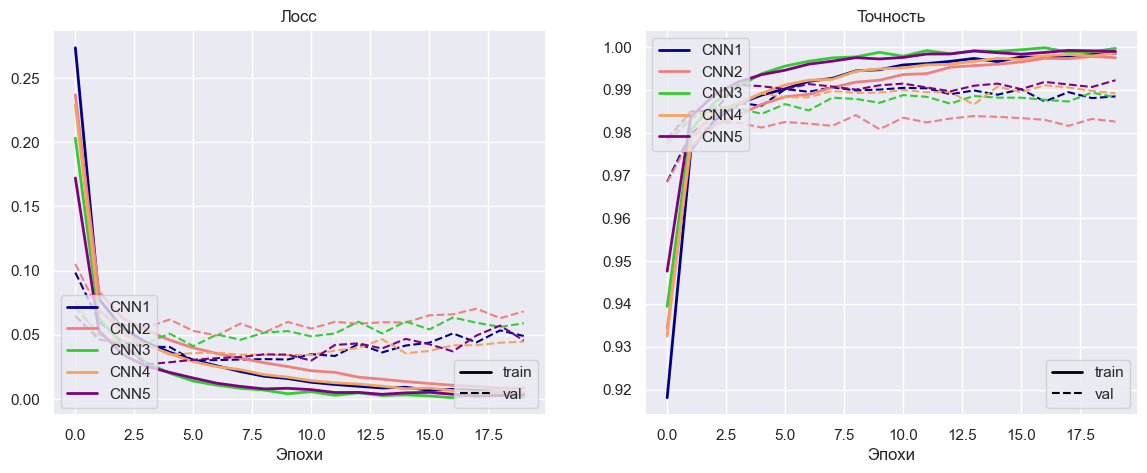

In [ ]:
plot_histories([history_cnn1, history_cnn2, history_cnn3, history_cnn4, history_cnn5], ["CNN1", "CNN2", "CNN3", "CNN4", "CNN5"])

Сделайте вывод. Как количество разных слоев влияет на качество и время обучения?

**Ответ:** количество слоев ускоряет обучение (видно, что за первые 10 эпох сети с бóльшим количеством слоев обучились лучше), но при слишном большом количестве обучаемых параметров (пример с 1214 тыс. параметров) переобучается и на валидационной выборке дает один из самых плохих результатов.

**Вывод по эксперименту 1:** важно правильно подобрать количество и последовательность слоев (как сверточных, так и линейный), чтобы получить оптимальную модель с хорошими результатами. На моем примере модель с двумя сверточными и двумя линейными слоями показала наилучший результат и точность около 0.99 на валидационной выборке.

**Эксперимент 2.** Теперь выберите лучший вариант, зафиксируйте это количество сверточных и линейных слоев и обучите хотя бы 4 сверточных нейросети, варьируя размеры ядер сверток. Например, в разном порядке поставьте ядра 3x3, 5x5.

In [ ]:
# У меня два сверточных слоя, поэтому можно регулировать их независимо, так получаем 4 модели

# ядра 3x3 и 3x3
cnn_3_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1400, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

# ядра 5x5 и 5x5
cnn_5_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=896, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

# ядра 5x5 и 3x3
cnn_5_3 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1400, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

# ядра 3x3 и 5x5
cnn_3_5 = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1400, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

print("CNN 3x3 и 3x3:", summary(cnn_3_3, input_size=(1, 1, 28, 28)))
print("CNN 5x5 и 5x5:", summary(cnn_5_5, input_size=(1, 1, 28, 28)))
print("CNN 5x5 и 3x3:", summary(cnn_5_3, input_size=(1, 1, 28, 28)))
print("CNN 3x3 и 5x5:", summary(cnn_3_5, input_size=(1, 1, 28, 28)))


CNN 3x3 и 3x3: ==========================================================================================
Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 28, 26, 26]           280
├─MaxPool2d: 1-2                         [1, 28, 13, 13]           --
├─ReLU: 1-3                              [1, 28, 13, 13]           --
├─Conv2d: 1-4                            [1, 56, 11, 11]           14,168
├─MaxPool2d: 1-5                         [1, 56, 5, 5]             --
├─ReLU: 1-6                              [1, 56, 5, 5]             --
├─Flatten: 1-7                           [1, 1400]                 --
├─Linear: 1-8                            [1, 256]                  358,656
├─ReLU: 1-9                              [1, 256]                  --
├─Linear: 1-10                           [1, 10]                   2,570
Total params: 375,674
Trainable para

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer1 = torch.optim.Adam(cnn_3_3.parameters())
optimizer2 = torch.optim.Adam(cnn_5_5.parameters())
optimizer3 = torch.optim.Adam(cnn_5_3.parameters())
optimizer4 = torch.optim.Adam(cnn_3_5.parameters())

# обучаем модели
history_cnn_3_3 = train(
    cnn_3_3,
    criterion,
    optimizer1,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn_5_5 = train(
    cnn_5_5,
    criterion,
    optimizer2,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn_5_3 = train(
    cnn_5_3,
    criterion,
    optimizer3,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

history_cnn_3_5 = train(
    cnn_3_5,
    criterion,
    optimizer4,
    train_batch_gen,
    val_batch_gen,
    num_epochs=20,
)

# сохраняем все состояния моделей, чтобы дальше загрузить одну из них
torch.save(cnn_3_3.state_dict(), "cnn_3_3.pth")
torch.save(cnn_5_5.state_dict(), "cnn_5_5.pth")
torch.save(cnn_5_3.state_dict(), "cnn_5_3.pth")
torch.save(cnn_3_5.state_dict(), "cnn_3_5.pth")

Epoch 20 of 20 took 6.804 s
  training loss: 	0.003044
  validation loss: 	0.044115
  training accuracy: 			99.91 %
  validation accuracy: 			99.11 %


Постройте график лосса и график accuracy, где сравниваются все модели этого эксперимента (на train и на val).

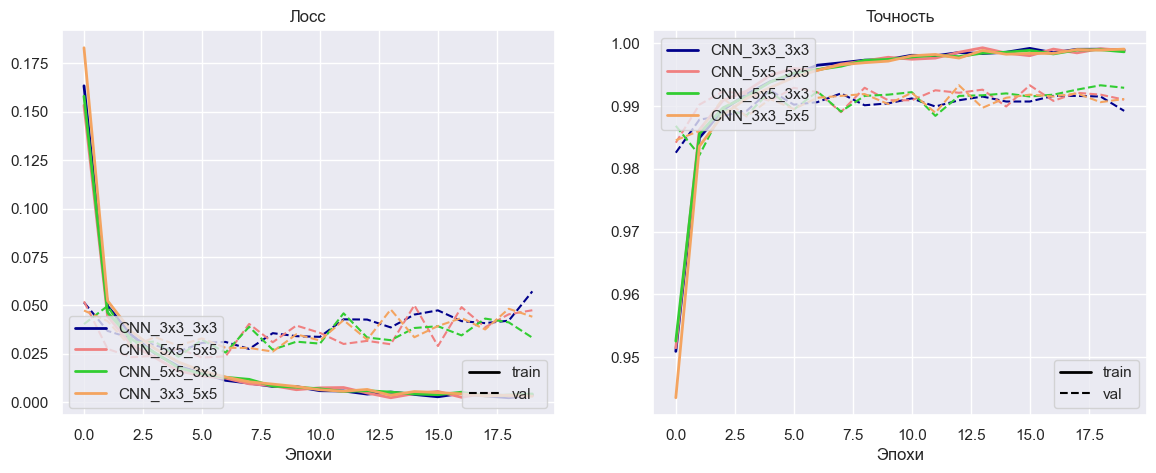

In [ ]:
plot_histories([history_cnn_3_3, history_cnn_5_5, history_cnn_5_3, history_cnn_3_5], ["CNN_3x3_3x3", "CNN_5x5_5x5", "CNN_5x5_3x3", "CNN_3x3_5x5"])

Сделайте вывод. Как размеры ядер влияют на качество и время обучения?

**Ответ:** бóльший размер ядер не всегда улучшает качество, но время обучений возрастает из-за требования бóльших вычислительных ресурсов.

**Вывод по эксперименту 2:** эксперимент показал, что важны не только последовательность и количество слоев, а еще и настройка параметров слоя (в нашем случае размеры ядер сверточных слоев). В следствии этого эксперимента я еще улучшил оптимальную модель из первого эксперимента, поменяв размеры ядер на 5х5 для первого сверточного слоя и 3х3 для второго.

**Анализ лучшей модели.** Выберите лучшую конфигурацию из всех по accuracy на валидации. Она должна быть не меньше 98%.

In [ ]:
# задаем структуру модели
optimal_model = nn.Sequential(
    nn.Conv2d(in_channels=1, out_channels=28, kernel_size=5),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Conv2d(in_channels=28, out_channels=56, kernel_size=3),
    nn.MaxPool2d(2),
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(in_features=1400, out_features=256),
    nn.ReLU(),
    nn.Linear(in_features=256, out_features=10),
).to(device)

# загружаем уже обученную модель
optimal_model.load_state_dict(torch.load("cnn_5_3.pth"))
optimal_model.eval()


Sequential(
  (0): Conv2d(1, 28, kernel_size=(5, 5), stride=(1, 1))
  (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (2): ReLU()
  (3): Conv2d(28, 56, kernel_size=(3, 3), stride=(1, 1))
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): ReLU()
  (6): Flatten(start_dim=1, end_dim=-1)
  (7): Linear(in_features=1400, out_features=256, bias=True)
  (8): ReLU()
  (9): Linear(in_features=256, out_features=10, bias=True)
)

Проведите еще один проход валидации выбранной моделью по всему датасету. В нем посчитайте точность по каждому классу и соберите информацию о неправильных предсказаниях. Равномерна ли точность по отношению к классам? Покажите 10-20 примеров, на которых нейросеть выдала неправильную метку. Что можно о них сказать?

Точность для каждого класса:
Цифра 0: 99.80%
Цифра 1: 99.82%
Цифра 2: 99.22%
Цифра 3: 99.21%
Цифра 4: 99.69%
Цифра 5: 99.33%
Цифра 6: 98.96%
Цифра 7: 98.93%
Цифра 8: 99.08%
Цифра 9: 98.81%


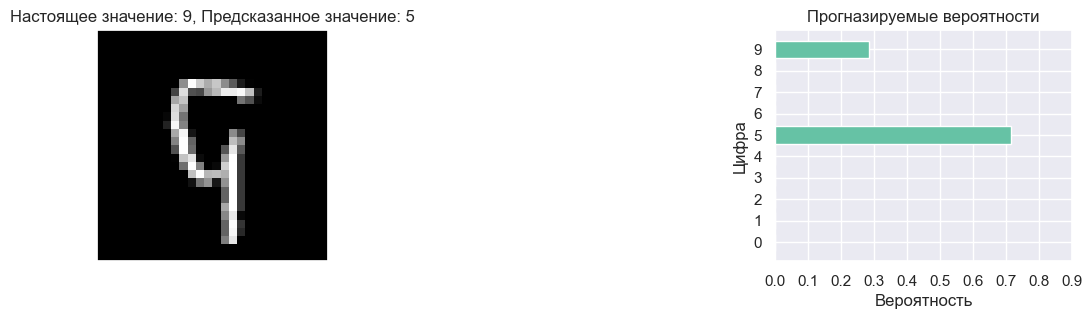

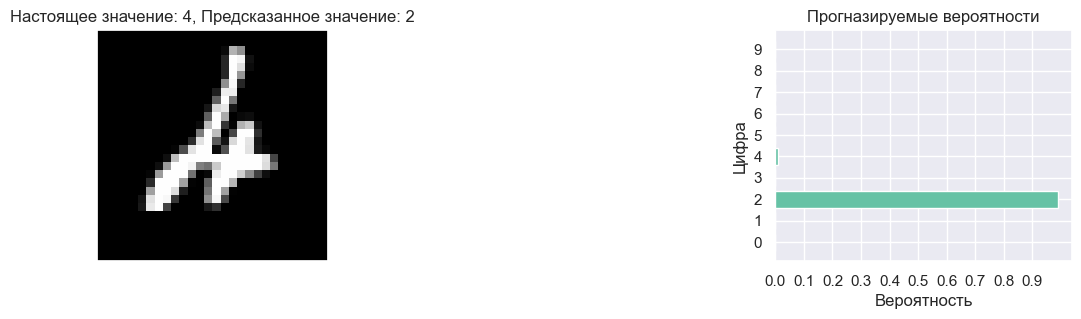

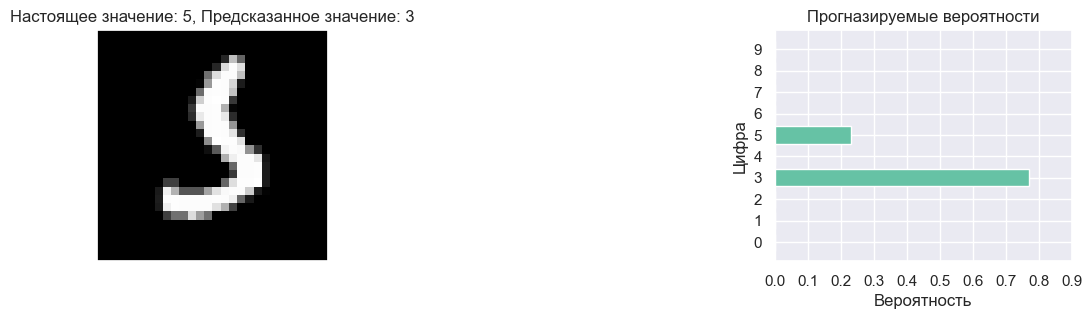

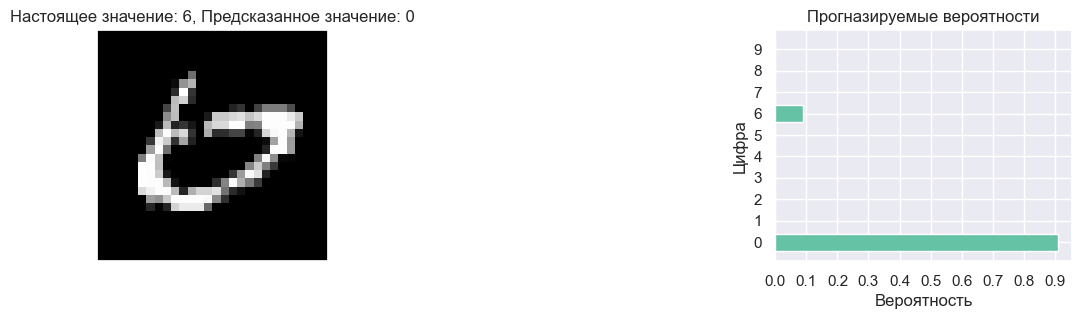

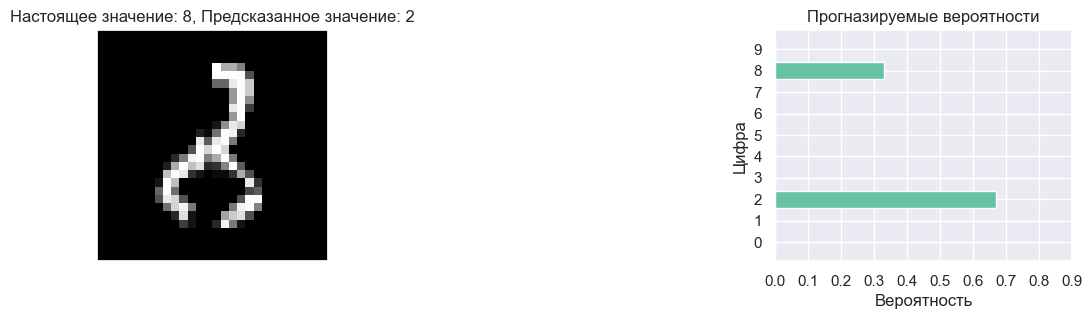

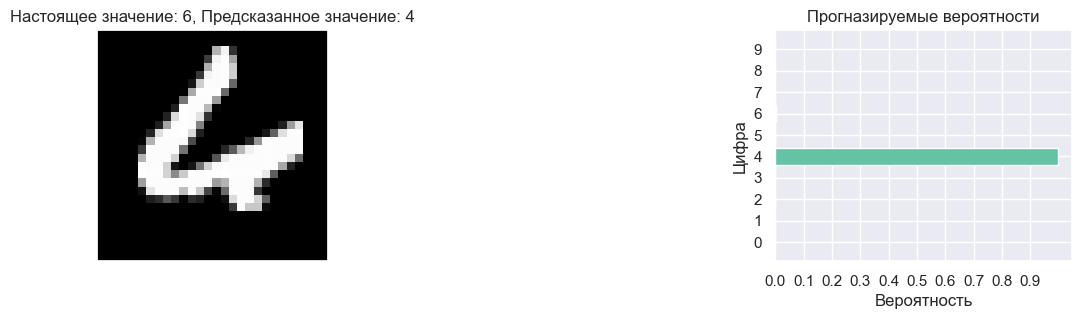

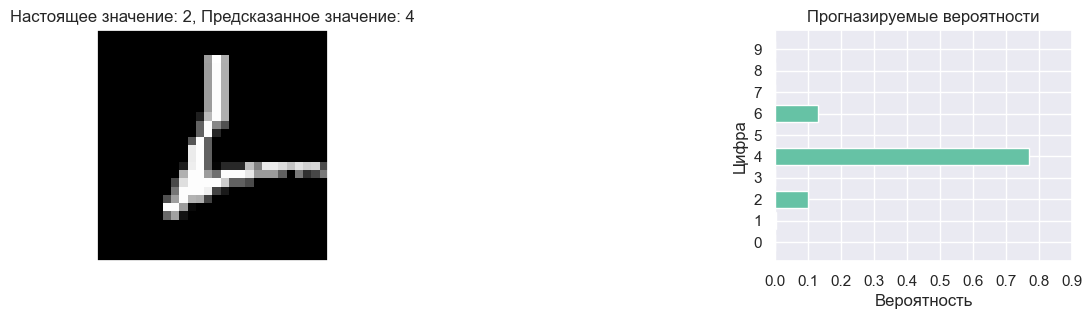

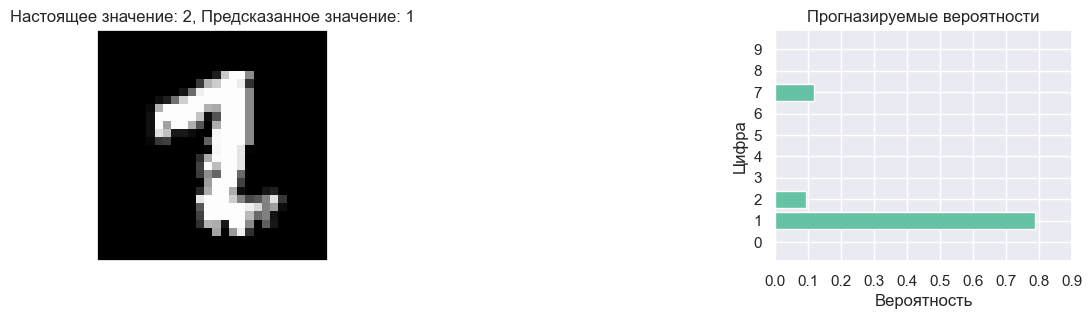

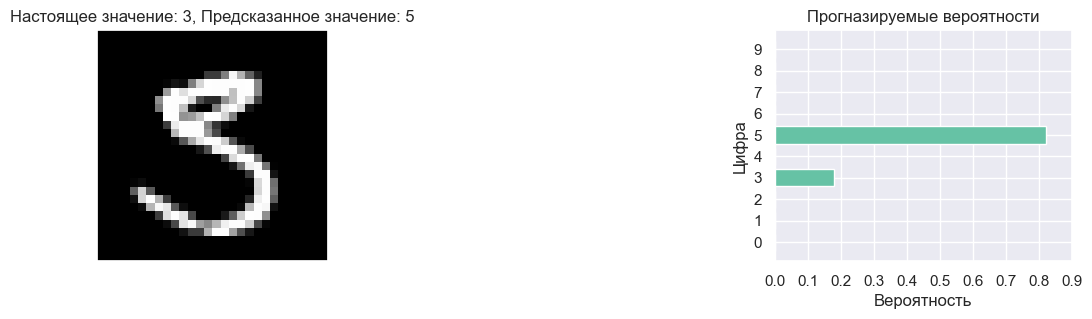

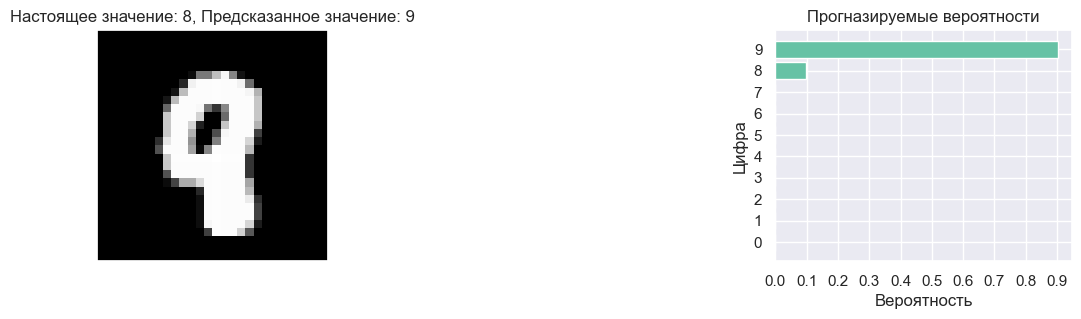

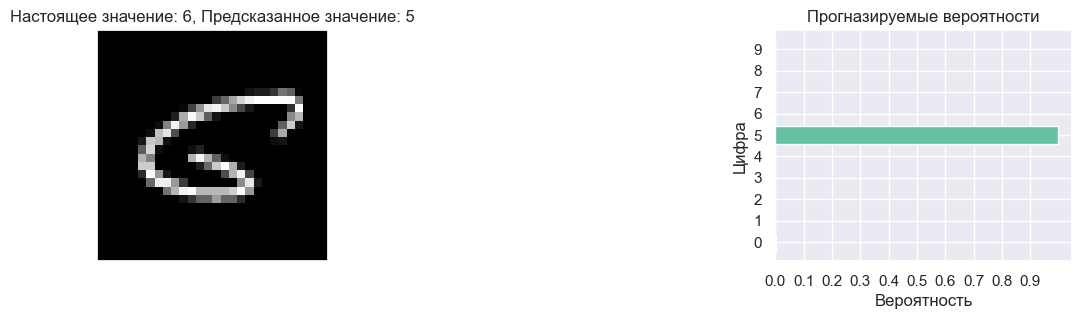

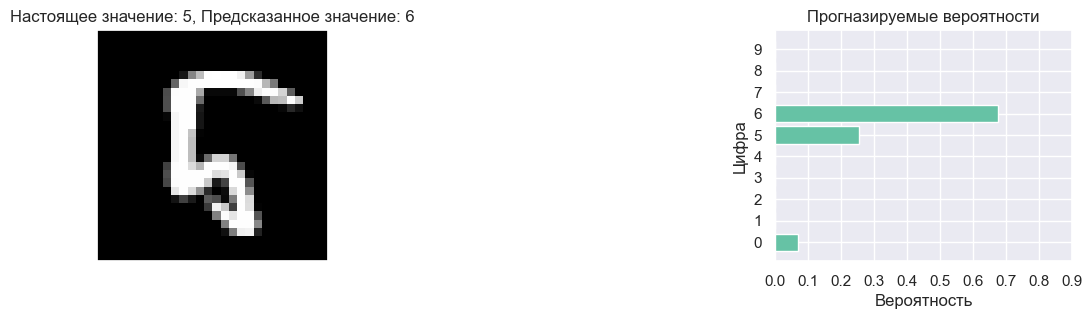

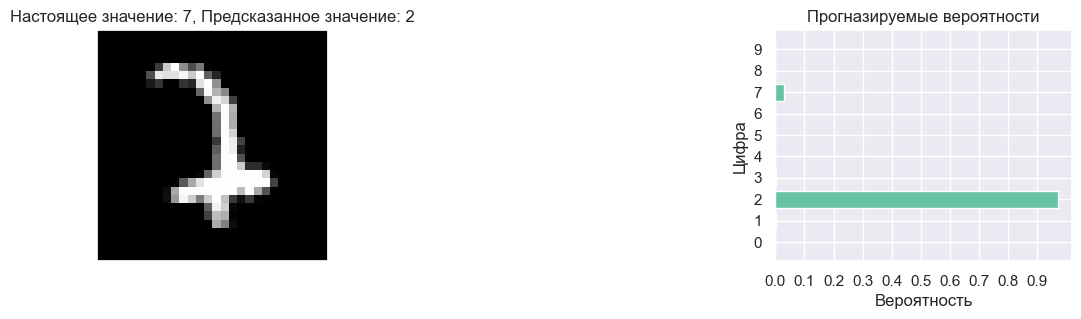

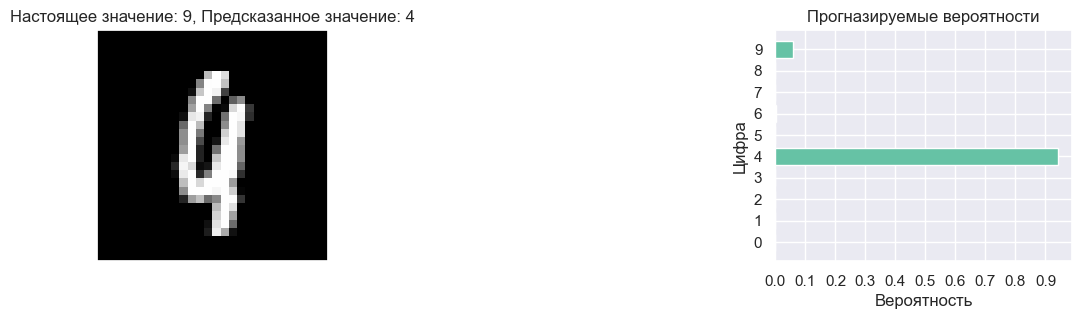

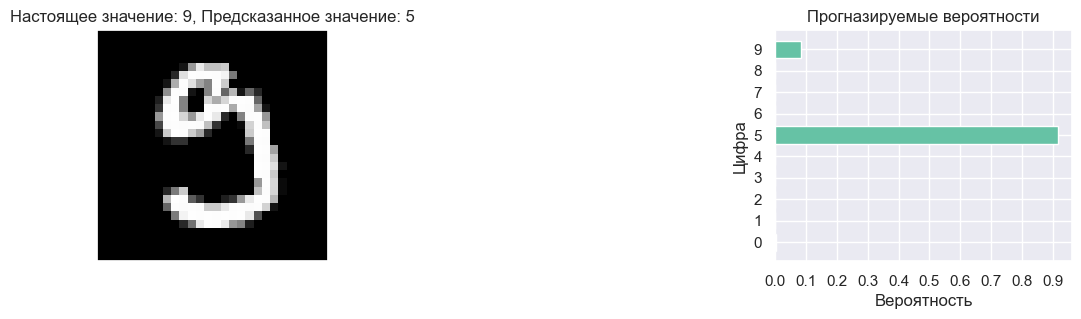

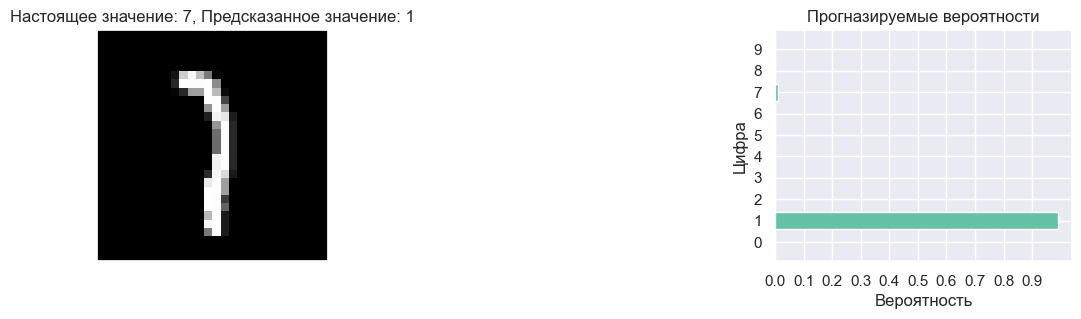

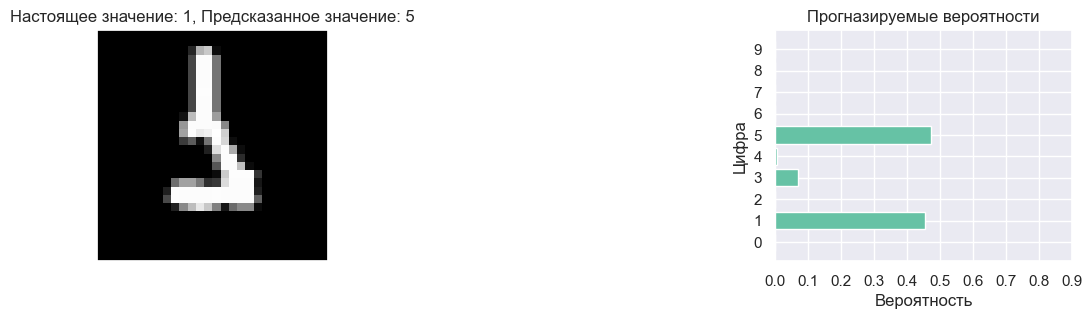

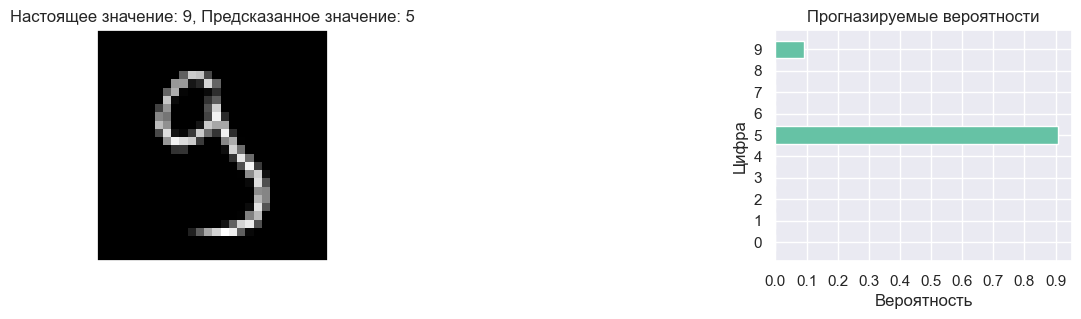

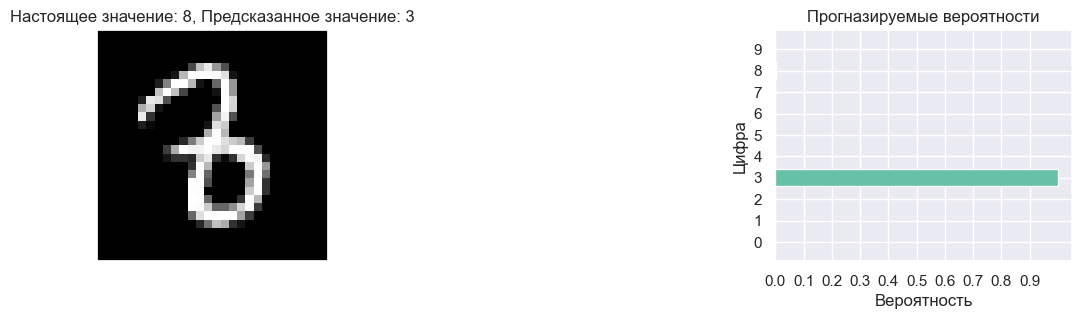

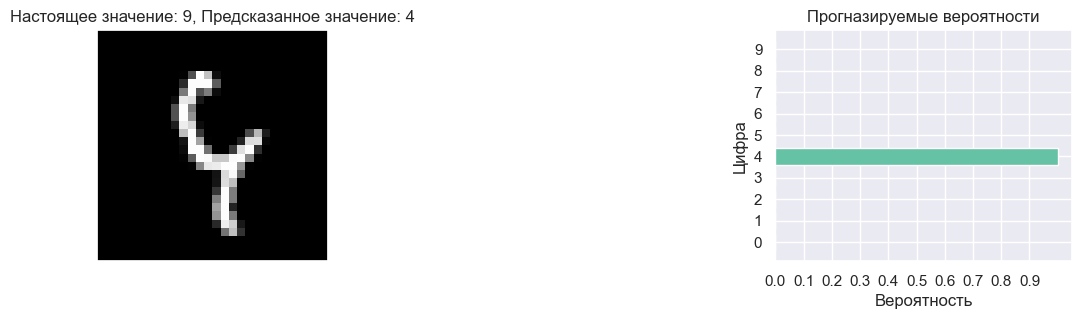

In [ ]:
def evaluate_model(model, val_batch_gen, device):
    correct = {i: 0 for i in range(10)}
    total = {i: 0 for i in range(10)}
    misclassified_examples = []

    with torch.no_grad():
        for images, labels in val_batch_gen:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            for i in range(len(labels)):
                label = labels[i]
                prediction = predicted[i]
                if prediction == label:
                    correct[label.item()] += 1
                else:
                    misclassified_examples.append((images[i], label.item(), prediction.item(), outputs[i]))
                total[label.item()] += 1

    accuracy_per_class = {i: correct[i] / total[i] for i in range(10)}
    overall_accuracy = sum(correct.values()) / sum(total.values())

    return accuracy_per_class, overall_accuracy, misclassified_examples

# Вызов функции для оценки модели
class_accuracy, overall_accuracy, misclassified_examples = evaluate_model(optimal_model, val_batch_gen, device)

print("Точность для каждого класса:")
for i in range(10):
    print(f"Цифра {i}: {class_accuracy[i]*100:.2f}%")

# Вывод неправильных предсказаний (примеры) с графиками вероятностей
for i in range(min(20, len(misclassified_examples))):
    image, true_label, predicted_label, output = misclassified_examples[i]
    with sns.axes_style("darkgrid"):
        plt.figure(figsize=(13, 3))

        # Вывод изображения
        plt.subplot(1, 3, 1)
        plt.imshow(image.squeeze().cpu().numpy(), cmap='gray')
        plt.title(f"Настоящее значение: {true_label}, Предсказанное значение: {predicted_label}")
        plt.xticks([])
        plt.yticks([])

        # Вывод графика вероятностей
        probabilities = torch.softmax(output, dim=0)
        plt.subplot(1, 3, 3)
        plt.barh(range(10), probabilities.cpu().numpy())
        plt.xticks(np.arange(0, 1, step=0.1))
        plt.yticks(range(10), [str(i) for i in range(10)])
        plt.title("Прогназируемые вероятности")
        plt.xlabel("Вероятность")
        plt.ylabel("Цифра")

        plt.show()

**Ответ:** выведенная статистика показывает, что точность равномерно распределена между значениями.

Сеть на некоторых картинках с "небольшими" дефектами дает вероятность и правильным ответам, но есть случаи, когда сеть предсказывает только другое значение с практически нулевой вероятностью правильного ответа (большая часть из этих картинок понятна даже не каждому человеку). Это показыает, как сеть учитывает глобальные и локальные патерны.

**Вывод по всей задаче:** я построил оптимальную модель из 5 изначально выбранных, изменяя количество слоев и параметры слоев, которая имеет высокую точность на валидационной выборке.

Задача показывает, как стоит подбирать количество слоев и их параметры. Также важно заметить, что для задач распознавания стоит учитывать локальные и глобальные патерны картинок, чтобы изменять настройки сети под них.

---
### Задача 2. Перенос стиля

Здесь вы потренируетесь в работе с картинками и составлением промптов. Используя код с <a href="https://miptstats.github.io/courses/ad_fivt/CV_complex_examples.html" target="_blank">семинара</a>, проведите перенос стиля на хотя бы 3 своих примерах.

> Заметьте, что в примерах с семинара в качестве картинок стиля и контента использовались картинки среднего разрешения. Если возникают проблемы: оптимизация останавливается на 0-й эпохе и не создает картинку; loss в какой-то момент стал nan; нехватка RAM; &mdash; то либо уменьшите разрешение ваших картинок, либо попробуйте картинку полегче.

In [ ]:
import os
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt

sns.set(palette="Set2")

!git clone https://github.com/nazianafis/Neural-Style-Transfer
# Перейдем в директорию скачанного репозитория
%cd /content/Neural-Style-Transfer/

# Небольшая обработка скрипта, не менять!
file_path = "NST.py"
with open(file_path, "r") as file:
    # Убираем автоматический запуск
    lines = file.readlines()[:183]
# Вывод логов только каждые 100 эпох
lines = lines[:175] + ["            if cnt % 100 == 0:\n"] + lines[175:]
lines[176] = "    " + lines[176]
with open(file_path, "w") as file:
    file.writelines(lines)

from NST import *

Cloning into 'Neural-Style-Transfer'...
remote: Enumerating objects: 379, done.
remote: Counting objects: 100% (154/154), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 379 (delta 72), reused 105 (delta 34), pack-reused 225
Receiving objects: 100% (379/379), 92.21 MiB | 21.36 MiB/s, done.
Resolving deltas: 100% (143/143), done.
/content/Neural-Style-Transfer


In [ ]:
def run_neural_style_transfer(content_image="c1.jpg", style_image="s1.jpg"):
    """
    Функция для запуска метода Neural Style Transfer.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :return: results_path -- путь к папке, в которую сохранился результат
    """
    PATH = ""
    default_resource_dir = os.path.join(PATH, "data")
    content_images_dir = os.path.join(default_resource_dir, "content-images")
    style_images_dir = os.path.join(default_resource_dir, "style-images")
    output_img_dir = os.path.join(default_resource_dir, "output-images")
    img_format = (4, ".jpg")

    # Задаем конфиги, включая вес компонент лосса
    optimization_config = {
        "content_img_name": content_image,
        "style_img_name": style_image,
        "height": 400,
        "content_weight": 100000.0,
        "style_weight": 15000.0,
        "tv_weight": 1.0,
    }
    optimization_config["content_images_dir"] = content_images_dir
    optimization_config["style_images_dir"] = style_images_dir
    optimization_config["output_img_dir"] = output_img_dir
    optimization_config["img_format"] = img_format

    results_path = neural_style_transfer(optimization_config)
    return results_path
def visualize_style_transfer(content_image, style_image, results_path):
    """
    Визуализация результатов.

    :param content_image: имя файла картинки контента
    :param style_image: имя файла картинки стиля
    :param results_path: путь к папке, в которую сохранился результат
    """
    if len(os.listdir(results_path)) == 0:
        return
    plt.figure(figsize=(13, 3))
    folders = [
        "content-images/",
        "output-images/" + Path(results_path).name + "/",
        "style-images/",
    ]
    combined_image = (
        Path(content_image).stem + "_" + Path(style_image).stem + ".jpg"
    )
    files = [content_image, combined_image, style_image]
    titles = ["Контент", "Результат", "Стиль"]
    for i in range(3):
        plt.subplot(1, 3, i + 1)
        plt.imshow(plt.imread("data/" + folders[i] + files[i]))
        plt.title(titles[i])
        plt.xticks([])
        plt.yticks([])

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:09<00:00, 59.2MB/s]


Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=1723348287488.0000, content_loss=      0.0000, style loss=1723341000000.0000, tv loss=7292753.0000
L-BFGS | iteration: 100, total loss=20779294720.0000, content_loss=1541638183.5938, style loss=19220229375.0000, tv loss=17426600.0000
L-BFGS | iteration: 200, total loss=7029975040.0000, content_loss=1512442675.7812, style loss=5498410312.5000, tv loss=19122344.0000
L-BFGS | iteration: 300, total loss=4241292032.0000, content_loss=1482870507.8125, style loss=2739169921.8750, tv loss=19251478.0000
L-BFGS | iteration: 400, total loss=3325354240.0000, content_loss=1452215332.0312, style loss=1854204726.5625, tv loss=18934220.0000
L-BFGS | iteration: 500, total loss=2926554624.0000, content_loss=1421443652.3438, style loss=1486473632.8125, tv loss=18637284.0000
L-BFGS | iteration: 600, total loss=2702011648.0000, content_loss=1397097265.6250, style loss=1286454492.1875, tv loss=18459844.0000
L-BFGS | iteration: 70

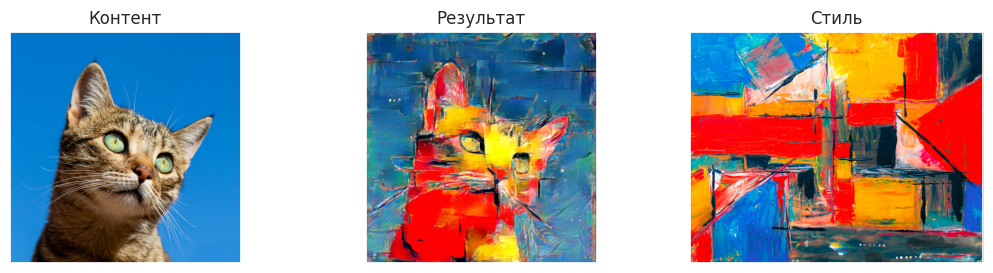

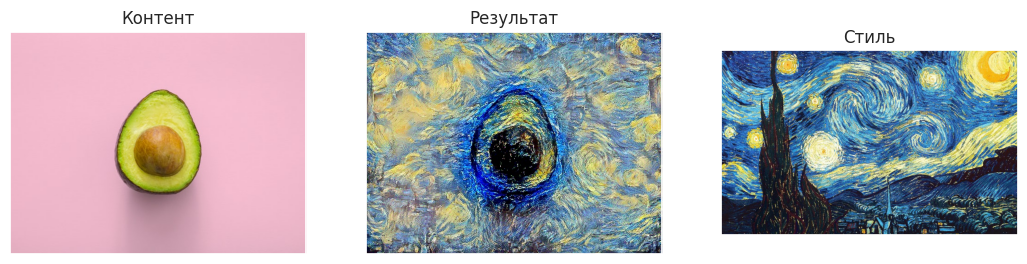

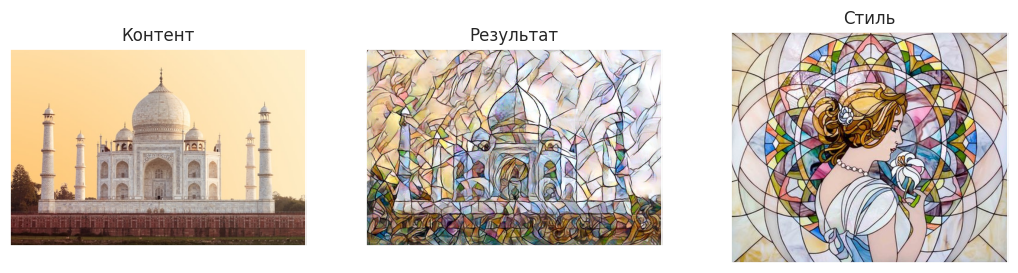

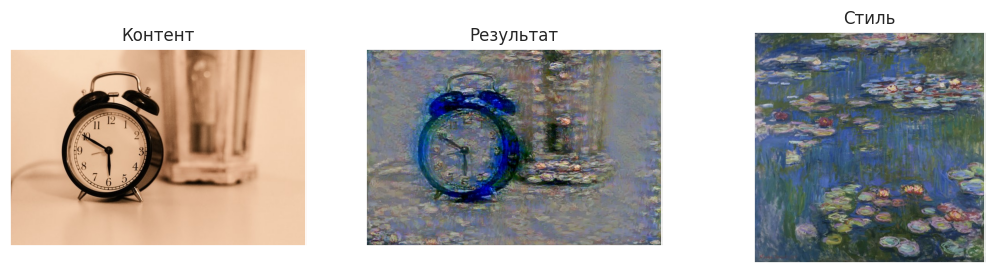

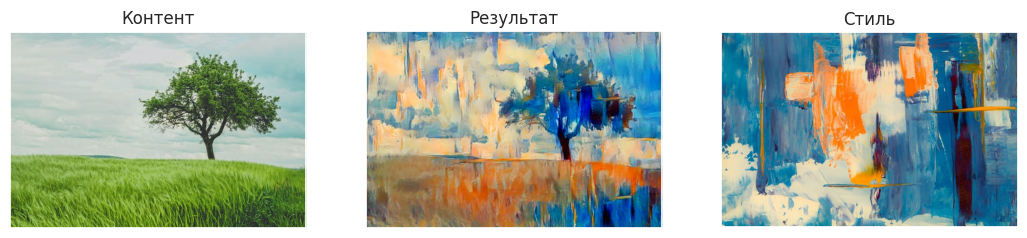

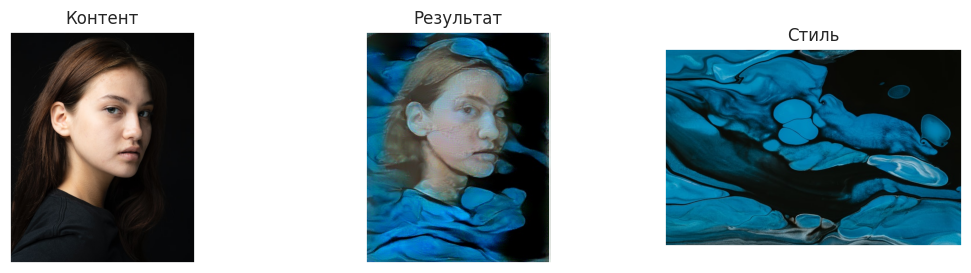

In [ ]:
content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))

result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)


for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

In [ ]:
# подключим Google Drive
from google.colab import drive

drive.mount("/content/drive")

# пути к нужным папкам в Drive
content_path = "/content/drive/MyDrive/DS/style_transfer_images/content"
style_path = "/content/drive/MyDrive/DS/style_transfer_images/style"




Mounted at /content/drive


In [ ]:
# очистим предыдущие картинки, скопируем новые
!rm -r data/content-images
!mkdir data/content-images
!cp -a /$content_path/. data/content-images/

!rm -r data/style-images
!mkdir data/style-images
!cp -a /$style_path/. data/style-images/

Using VGG19 in the optimization procedure.
L-BFGS | iteration: 000, total loss=1649904320512.0000, content_loss=      0.0000, style loss=1649895240000.0000, tv loss=9042018.0000
L-BFGS | iteration: 100, total loss=23117338624.0000, content_loss=1955084765.6250, style loss=21140919375.0000, tv loss=21333670.0000
L-BFGS | iteration: 200, total loss=9064805376.0000, content_loss=1973409570.3125, style loss=7068330000.0000, tv loss=23065728.0000
L-BFGS | iteration: 300, total loss=5827251712.0000, content_loss=1945319921.8750, style loss=3858553593.7500, tv loss=23378600.0000
L-BFGS | iteration: 400, total loss=4716827136.0000, content_loss=1921553515.6250, style loss=2771941171.8750, tv loss=23332532.0000
L-BFGS | iteration: 500, total loss=4192167680.0000, content_loss=1901237304.6875, style loss=2267544140.6250, tv loss=23386260.0000
L-BFGS | iteration: 600, total loss=3890925056.0000, content_loss=1882888085.9375, style loss=1984577343.7500, tv loss=23459924.0000
L-BFGS | iteration: 70

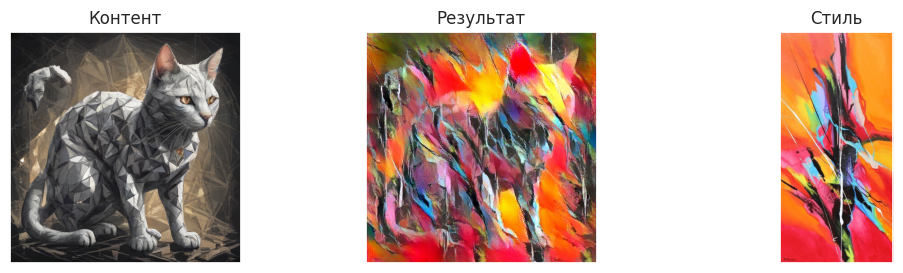

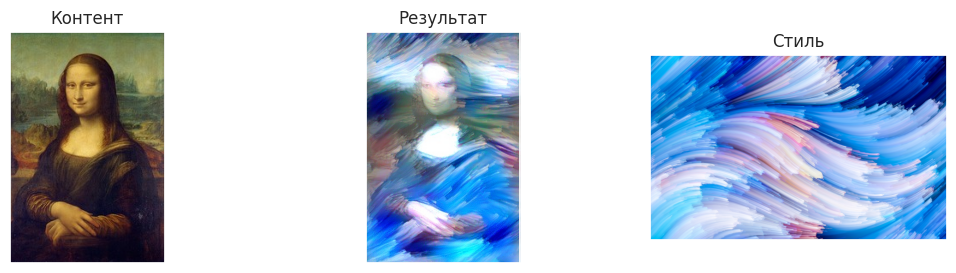

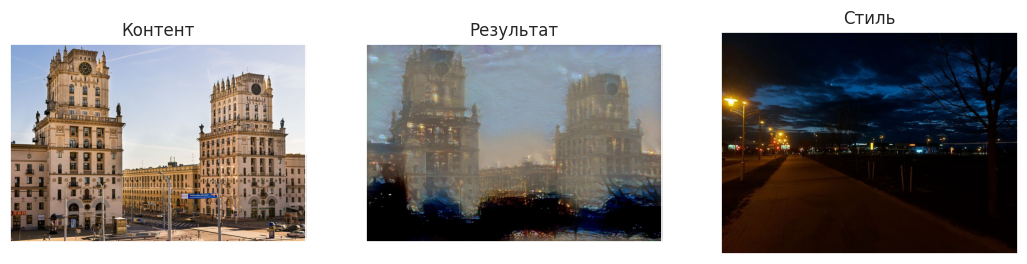

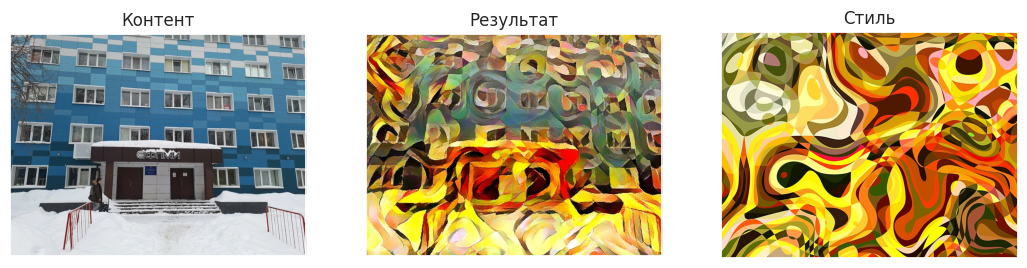

In [ ]:

content_images = sorted(os.listdir("data/content-images"))
style_images = sorted(os.listdir("data/style-images"))
result_paths = []
for content_image, style_image in zip(content_images, style_images):
    results_path = run_neural_style_transfer(content_image, style_image)
    result_paths.append(results_path)


# Сохраним результаты
!cp -r data/output-images /content/drive/MyDrive/DS

# Визуализируем
for content_image, style_image, results_path in zip(
    content_images, style_images, result_paths
):
    visualize_style_transfer(content_image, style_image, results_path)

Теперь для каждой пары контекст-стиль попытайтесь сгенерировать картинку с таким контекстом и стилем с помощью диффузионной модели, рассмотренной на семинаре, задав нужный промпт.

In [1]:
!pip install -q diffusers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 6.4 MB/s eta 0:00:00


In [2]:
from diffusers import AutoPipelineForText2Image
import torch

pipe = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/sdxl-turbo", torch_dtype=torch.float16, variant="fp16"
).to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Fetching 18 files:   0%|          | 0/18 [00:00<?, ?it/s]

text_encoder_2/config.json:   0%|          | 0.00/575 [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/586 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/704 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/565 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer_2/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

tokenizer_2/tokenizer_config.json:   0%|          | 0.00/855 [00:00<?, ?B/s]

tokenizer_2/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer_2/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/1.39G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/1.78k [00:00<?, ?B/s]

model.fp16.safetensors:   0%|          | 0.00/246M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.fp16.safetensors:   0%|          | 0.00/5.14G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

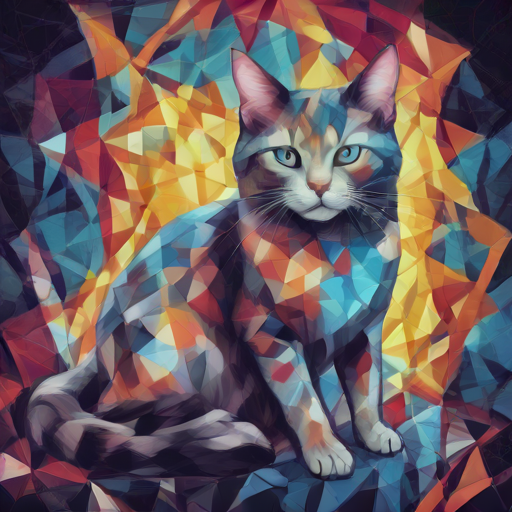

In [ ]:
prompt = "a cat as the ultimate autonomous entity with sacred geometry infused with an abstract painting style featuring vibrant, contrasting colors, artstation, slightly blurry"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

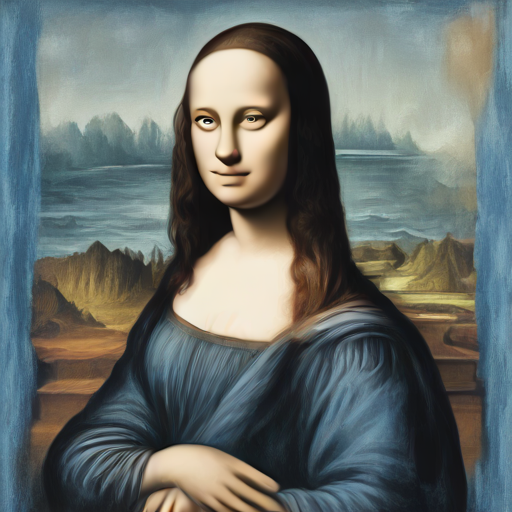

In [5]:
prompt = "realistic Mona Lisa with blue and blue brush stroke style"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

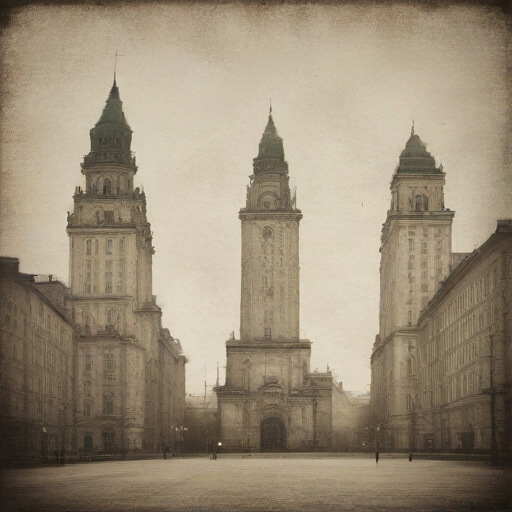

In [6]:
prompt = "a square in Minsk with two towers in the style of faded photography"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

  0%|          | 0/1 [00:00<?, ?it/s]

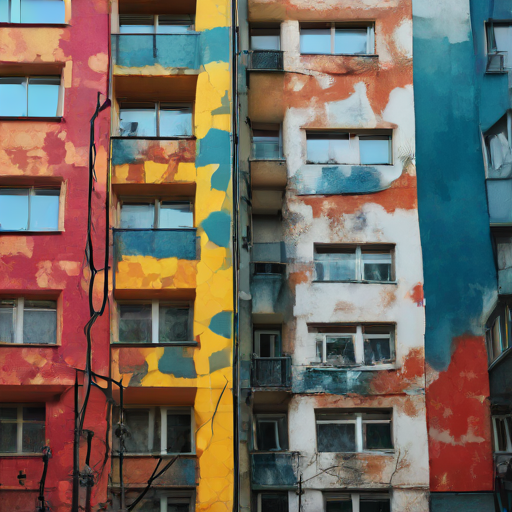

In [ ]:
prompt = "Moscow Institute of Physics and Technology hostel outdoors with an abstract painting style featuring vibrant, contrasting colors, slightly blurry"
image = pipe(prompt=prompt, num_inference_steps=1, guidance_scale=0.0).images[0]
image

**Вывод:**
Для первой части я пробовал много разных картинок, но подобрать подходящий стиль для изображения оказалось не простой задачей. Одна из картинок (кот) является сгенерированной картинкой диффузионной модели. В основном я использовал картинки для стиля из интернета, но на картинке, где изображены две башни (вокзал в Минске) в качестве стиля я взял фотографию, которую когда-то сделал сам, гуляя по ночному городу. Результат удивил, потому что получилась будто старая выцветшая фотография башень. По первой части я узнал, как сверточными сетями можно смешать контент и стиль различных изображений, использую обычные ошибки и оптимизируя градиентным спуском.

Аналогично для второй части я пробовал разные промты, но подобрать что-то похожее на изображения из первой части мне не удалось, хотя изображения получились интересные. Из показанных примеров точно можно сделать вывод, что лица данная диффузионная модель генерирует плохо, потому что лицо Мона Лизы получилось не очень человеческое.